In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_palette("husl")

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

**Groundwater is an important source of water stored in the earth beneath our feet, in spaces between sand, soils, and fractured rock known as an aquifer. Layers of aquifers make up a groundwater basin. During an average year, California's groundwater basins and subbasins contribute approximately 38 percent toward the State's total water supply. During dry years, groundwater contributes up to 46 percent (or more) of the statewide annual supply. On agricultural regions, it serves as a critical buffer against the impacts of drought and climate change, but it is also where there is a higher risk of over-exploitation.** 

**Groundwater level in agricultural regions is affected by multiple factors such as the climate, geological characteristics of the soil, rate of groundwater extraction and surface water flows. All these factors have a complex nonlinear relationship with the groundwater level which makes accurate physical process simulations very challenging. Therefore, it is appealing to consider machine learning methods that may be able to predict groundwater level fluctuation without a thorough understanding of the physic laws that govern groundwater flows. Several academical studies have demonstrated the ability of statistical and machine learning methods for capturing the nonlinear relation between climate variables and groundwater, particularly in areas in which physically based models would be challenging to implement.**

**My objective is to create a model that is able to forecast medium-term (1 year ahead) trends on groundwater level for one of the California Basin Aquifers (Cuyama in Santa Barbara County).  If successful, it could be a tool that can help stakeholders make investment decisions like acquiring farming land that is irrigated with groundwater or establishing a crop like fruit trees that will require the use of groundwater for years into the future.**

**In order to create the model, I am going to use Ground Water data publicly available from the Water Department of the US Geological Service and from the California Department of Water Resources. I am also using Climate Data from the University of California Agriculture and Natural Resources.** 

**In addition to data processing and featuring engineering, I’m planning to use Time Series in combination with regression techniques to try to predict the groundwater level fluctuation.**







## Climate Data

**The climate data I am going to use is a combination of climate data from the Water Department of the US Geological Service and Climate Data from the University of California Agriculture and Natural Resources.**


In [2]:
dfclimate = pd.read_csv('18060007_climate.csv')


In [3]:
# This will fill empty cells with nan values
dfclimate = dfclimate.replace(r'^\s*$', np.nan, regex=True)

In [4]:
dfclimate.head(5)

,Date,Precip,Air max,min,Soil max,min.1,Solar,ETo
0,09/01/08,0,27.2,7.8,22.2,19.4,268,NaN
1,09/02/08,0,32.8,8.3,21.7,19.4,254,NaN
2,09/03/08,0,35.0,11.1,21.7,19.4,269,NaN
3,09/04/08,0,36.1,12.2,21.1,18.9,261,NaN
4,09/05/08,0,36.1,13.3,21.1,18.9,258,NaN


In [5]:
dfclimate.isna().sum()


Date         0
Precip       0
Air max      0
min          0
Soil max     0
min.1        0
Solar        0
ETo         83
dtype: int64

**I am missing 83 ETo Values. ETo is short for Evapotranspiration which is defined as the process by which water is transferred from the land to the atmosphere by evaporation from the soil and other surfaces and by transpiration from plants. The value of ETo is a function of the climate conditions, so I am going to use the other climate variables I have to calculate the missing ETo values.**

In [6]:
#I am going to separate the dataframe into 2 df, one containing the rows where I am missing ETo values and a second
# where I have ETo values. The former df is the one I will use to train the model. 
train = dfclimate[dfclimate['ETo'].notnull()]
test = dfclimate[dfclimate['ETo'].isnull()]


In [7]:
# Data to train the ETo model
X = train.loc[:, ~(train.columns).isin(['Date','ETo', 'Precip','Actual Evo'])]
y = train.loc[:, (train.columns).isin(['ETo'])]

In [8]:
# I am going to use GradientBoosting to create the eto model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score


In [9]:
clf = GradientBoostingRegressor()
from sklearn.metrics import make_scorer, explained_variance_score
from sklearn.model_selection import GridSearchCV



parameters = {'n_estimators': [100,200], 
              'min_samples_split':[2,4,6], 
              'max_depth':[2,3,4],
              'min_samples_leaf': [2,3,4],
              'learning_rate': [0.1,0.2]             }

acc_scorer = make_scorer(explained_variance_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer,n_jobs=4)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=4,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
rfrscore = cross_val_score(clf, X, y, cv=5)
print (rfrscore)
print("rfrscore: %0.4f (+/- %0.4f)" % (rfrscore.mean(),rfrscore.std() * 2))

[0.93821699 0.97659184 0.971348   0.97868557 0.94313925]
rfrscore: 0.9616 (+/- 0.0346)


**The ETo model seems to do a good job of predicting ETo, so I am going to use it to calculate the ETo for the empty rows**


In [11]:
X_predict = test.loc[:, ~(test.columns).isin(['Date','ETo', 'Precip','Actual Evo'])]


In [12]:
predicted = clf.predict(X_predict)
predicted = predicted

In [13]:
predicted

array([5.25380517, 5.25885269, 6.14856208, 6.13596677, 6.10017401,
       6.45806034, 6.53920868, 6.53920868, 6.31643058, 5.24643592,
       5.36068044, 5.50130648, 5.28387369, 6.01286538, 5.93292374,
       5.93292374, 5.30720276, 4.86492598, 4.85382793, 4.66964074,
       4.50228991, 4.20211454, 5.54993711, 5.80475457, 7.02575986,
       6.42891861, 5.92649742, 6.39938121, 6.19376988, 6.15515732,
       6.70006142, 6.59779001, 4.00281731, 0.30896289, 6.59779001,
       6.9900742 , 6.58844345, 6.93703924, 6.86154985, 6.89266577,
       6.62898448, 4.30123178, 4.30123178, 4.30123178, 1.63391234,
       1.42670503, 1.57202164, 2.01964231, 1.87187335, 1.98020915,
       2.10706136, 2.19310618, 2.38171282, 1.83627961, 2.47201777,
       2.59818212, 2.47201777, 2.47201777, 2.59818212, 2.47201777,
       2.66820392, 3.02881448, 2.95159236, 2.92966678, 3.1741882 ,
       4.09183925, 4.09183925, 3.89506578, 3.82217865, 4.28236729,
       4.41797044, 4.54662076, 5.07768016, 5.20091168, 6.11990

In [14]:
test['ETo']= predicted

In [15]:
test.head(5)

,Date,Precip,Air max,min,Soil max,min.1,Solar,ETo
0,09/01/08,0,27.2,7.8,22.2,19.4,268,5.253805
1,09/02/08,0,32.8,8.3,21.7,19.4,254,5.258853
2,09/03/08,0,35.0,11.1,21.7,19.4,269,6.148562
3,09/04/08,0,36.1,12.2,21.1,18.9,261,6.135967
4,09/05/08,0,36.1,13.3,21.1,18.9,258,6.100174


In [16]:
# Here I am joining both dataframes again to create one without missing values. 
dfclimate = pd.concat([train, test])
dfclimate = dfclimate.sort_index()

In [17]:
len(dfclimate)

2313

In [18]:
type(dfclimate["Date"][0])

str

In [19]:
#it seems that the Date column is made up of strings that look like Date, so I am going to convert it to Datetime. 
dfclimate['date'] = pd.to_datetime(dfclimate['Date'])


In [20]:
#I am going to use the date column as index
dfclimate.index = dfclimate['date']

In [21]:
dfclimate.head(5)

,Date,Precip,Air max,min,Soil max,min.1,Solar,ETo,date
date,,,,,,,,,
2008-09-01,09/01/08,0,27.2,7.8,22.2,19.4,268,5.25381,2008-09-01
2008-09-02,09/02/08,0,32.8,8.3,21.7,19.4,254,5.25885,2008-09-02
2008-09-03,09/03/08,0,35.0,11.1,21.7,19.4,269,6.14856,2008-09-03
2008-09-04,09/04/08,0,36.1,12.2,21.1,18.9,261,6.13597,2008-09-04
2008-09-05,09/05/08,0,36.1,13.3,21.1,18.9,258,6.10017,2008-09-05


In [22]:
#I am dropping the two extra dates columns now that date is on the index
dfclimate = dfclimate.drop(['Date', 'date'], axis=1)

In [23]:
# I am also going to drop the columns Air max, min, soil max, and min.1. ETo is a function that summarizes all the data in
#these columns, it is kind of a PCA for water use.   
dfclimate = dfclimate.drop(['Air max', 'min','Soil max','min.1','Solar'], axis=1)

**My goal is to calculate the water depth a year in the future, here I am calculating the sum of the precipitation and ETo for the following 6 months after a given data, and for the 6 to 12 months period ahead.**

In [24]:
dfclimate['6_m_Prec_f'] = dfclimate['Precip'].rolling(182, win_type='boxcar', center=True).sum().shift(-91)
dfclimate['6_m_ETo_f'] = dfclimate['ETo'].rolling(182, win_type='boxcar', center=True).sum().shift(-91)
dfclimate['6-12_m_Prec_f'] = dfclimate['Precip'].rolling(182, win_type='boxcar', center=True).sum().shift(-273)
dfclimate['6-12_m_ETo_f'] = dfclimate['ETo'].rolling(182, win_type='boxcar', center=True).sum().shift(-273)

In [25]:
dfclimate.head(5)

,Precip,ETo,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f
date,,,,,,
2008-09-01,0,5.25381,243.0,516.089280,34.0,1077.763027
2008-09-02,0,5.25885,244.0,514.388475,33.0,1081.063027
2008-09-03,0,6.14856,246.0,512.682622,31.0,1083.601027
2008-09-04,0,6.13597,256.0,507.549060,21.0,1089.185027
2008-09-05,0,6.10017,260.0,504.205094,17.0,1092.992027


## GroundWater Data

**I have data for 5 different wells in the Cuyama Basin. I am going to load and process the data for the 5 wells, and analyze what data I am going to use for the model.** 

In [26]:
#Loading the data for well 345552119354204, I am going to use the shortname 204 for this well.
Well_204= pd.read_excel(open('cuyama.xls','rb'), sheet_name='345552119354204')


In [27]:
Well_204.head(5)

,Date,204 Depth
0,2009-03-24,379.33
1,2009-03-25,379.52
2,2009-03-26,379.8
3,2009-03-27,380.13
4,2009-03-28,380.41


In [28]:
#Adding data to the index.
Well_204.index = Well_204['Date']


In [29]:
#There are some empty rows, so I am going to fill those rows with nan values
Well_204 = Well_204.replace(r'^\s*$', np.nan, regex=True)


In [30]:
Well_204.isna().sum()


Date         0
204 Depth    4
dtype: int64

In [31]:
#I am going to fill up the nan rows with the values from the previous row
Well_204 = Well_204.fillna(method='bfill')
Well_204.isna().sum()


Date         0
204 Depth    0
dtype: int64

In [32]:
Well_204.head(5)

,Date,204 Depth
Date,,
2009-03-24,2009-03-24,379.33
2009-03-25,2009-03-25,379.52
2009-03-26,2009-03-26,379.80
2009-03-27,2009-03-27,380.13
2009-03-28,2009-03-28,380.41


In [33]:
#I am going to the same for the other 4 wells.

Well_201= pd.read_excel(open('cuyama.xls','rb'), sheet_name='345538119332201')

Well_201.index = Well_201['Date']

Well_201 = Well_201.replace(r'^\s*$', np.nan, regex=True)


Well_201 = Well_201.fillna(method='ffill')


Well_104= pd.read_excel(open('cuyama.xls','rb'), sheet_name='345351119323104')

Well_104.index = Well_104['Date']

Well_104 = Well_104.replace(r'^\s*$', np.nan, regex=True)


Well_104 = Well_104.fillna(method='ffill')



Well_002= pd.read_excel(open('cuyama.xls','rb'), sheet_name='345100119290002')

Well_002.index = Well_002['Date']

Well_002 = Well_002.replace(r'^\s*$', np.nan, regex=True)


Well_002 = Well_002.fillna(method='ffill')



Well_001= pd.read_excel(open('cuyama.xls','rb'), sheet_name='344825119271001')

Well_001.index = Well_001['Date']

Well_001 = Well_001.replace(r'^\s*$', np.nan, regex=True)


Well_001 = Well_001.fillna(method='ffill')



In [114]:
#I am going to join the date for all the wells in one dataframe
df_wells = pd.concat([Well_201, Well_002,Well_001,Well_104,Well_204], axis=1, sort=False)

df_wells.head(5)

,Date,201 Depth,Date,002 Depth,Date,001 Depth,Date,104 Depth,Date,204 Depth
Date,,,,,,,,,,
2009-03-24,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2009-03-24,379.33
2009-03-25,2009-03-25,468.91,2009-03-25,70.94,NaT,NaN,NaT,NaN,2009-03-25,379.52
2009-03-26,2009-03-26,468.77,2009-03-26,71.27,NaT,NaN,NaT,NaN,2009-03-26,379.80
2009-03-27,2009-03-27,468.78,2009-03-27,71.26,NaT,NaN,NaT,NaN,2009-03-27,380.13
2009-03-28,2009-03-28,468.74,2009-03-28,73.72,NaT,NaN,NaT,NaN,2009-03-28,380.41


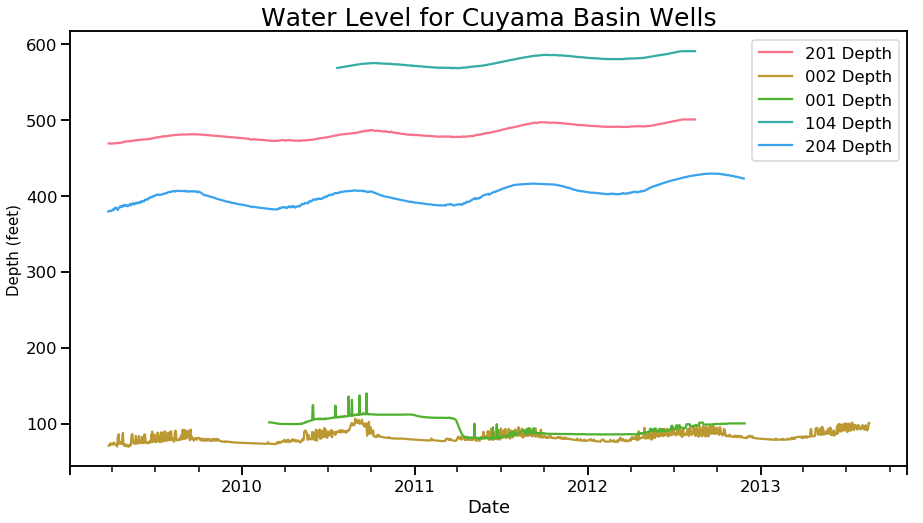

In [117]:
# plotting the water level for each well against date to see the quality of the data.
f, ax= plt.subplots(figsize=(15, 8))
df_wells.plot( y=1, ax=ax)
df_wells.plot( y=3, ax=ax)
df_wells.plot( y=5, ax=ax)
df_wells.plot( y=7, ax=ax)
df_wells.plot( y=9, ax=ax)
plt.ylabel('Depth (feet)',fontsize=15)
plt.title('Water Level for Cuyama Basin Wells',fontsize=25)
f.savefig('wells.png', bbox_inches = "tight")


plt.show()

**The plot shows that the data quality for wells 001 and 002 it is really poor with a lot of outliers, so I am going to discard the data for those two wells.**

In [36]:
df_wells = df_wells.loc[:, (df_wells.columns).isin(['201 Depth', '104 Depth', '204 Depth'])]

In [37]:
df_wells.head(5)

,201 Depth,104 Depth,204 Depth
Date,,,
2009-03-24,NaN,NaN,379.33
2009-03-25,468.91,NaN,379.52
2009-03-26,468.77,NaN,379.80
2009-03-27,468.78,NaN,380.13
2009-03-28,468.74,NaN,380.41


In [38]:
# I am going to join the wells dataframe and the climate dataframe
df_c_w = pd.concat([df_wells, dfclimate], axis=1, sort=False)

In [39]:
df_c_w.head(5)

,201 Depth,104 Depth,204 Depth,Precip,ETo,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f
2008-09-01,NaN,NaN,NaN,0,5.25381,243.0,516.089280,34.0,1077.763027
2008-09-02,NaN,NaN,NaN,0,5.25885,244.0,514.388475,33.0,1081.063027
2008-09-03,NaN,NaN,NaN,0,6.14856,246.0,512.682622,31.0,1083.601027
2008-09-04,NaN,NaN,NaN,0,6.13597,256.0,507.549060,21.0,1089.185027
2008-09-05,NaN,NaN,NaN,0,6.10017,260.0,504.205094,17.0,1092.992027


In [40]:
#My goal is to predict the value of water depth for a year ahead, so I am going to create a new column for each well with
#the delta year over year. 
df_c_w['201_12_month_delta'] = df_c_w['201 Depth'].diff(periods=-365)
df_c_w['104_12_month_delta'] = df_c_w['104 Depth'].diff(periods=-365)
df_c_w['204_12_month_delta'] = df_c_w['204 Depth'].diff(periods=-365)


In [41]:
df_c_w.sample(5)

,201 Depth,104 Depth,204 Depth,Precip,ETo,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,201_12_month_delta,104_12_month_delta,204_12_month_delta
2008-11-02,NaN,NaN,NaN,6,2.538,268.0,503.314000,46.0,1100.605027,NaN,NaN,NaN
2010-08-15,481.76,570.98,406.02,0,6.853,471.0,564.534963,393.0,939.609000,-10.97,-10.49,-9.025455
2014-03-25,NaN,NaN,NaN,1,3.17419,30.0,1172.752107,NaN,NaN,NaN,NaN,NaN
2010-03-29,473.03,NaN,384.89,0,4.822,94.0,1106.294817,824.0,415.551963,-4.57,NaN,-2.980000
2010-09-09,484.04,573.45,406.61,0,4.822,600.0,456.665963,264.0,1044.684000,-11.83,-10.52,-9.315000


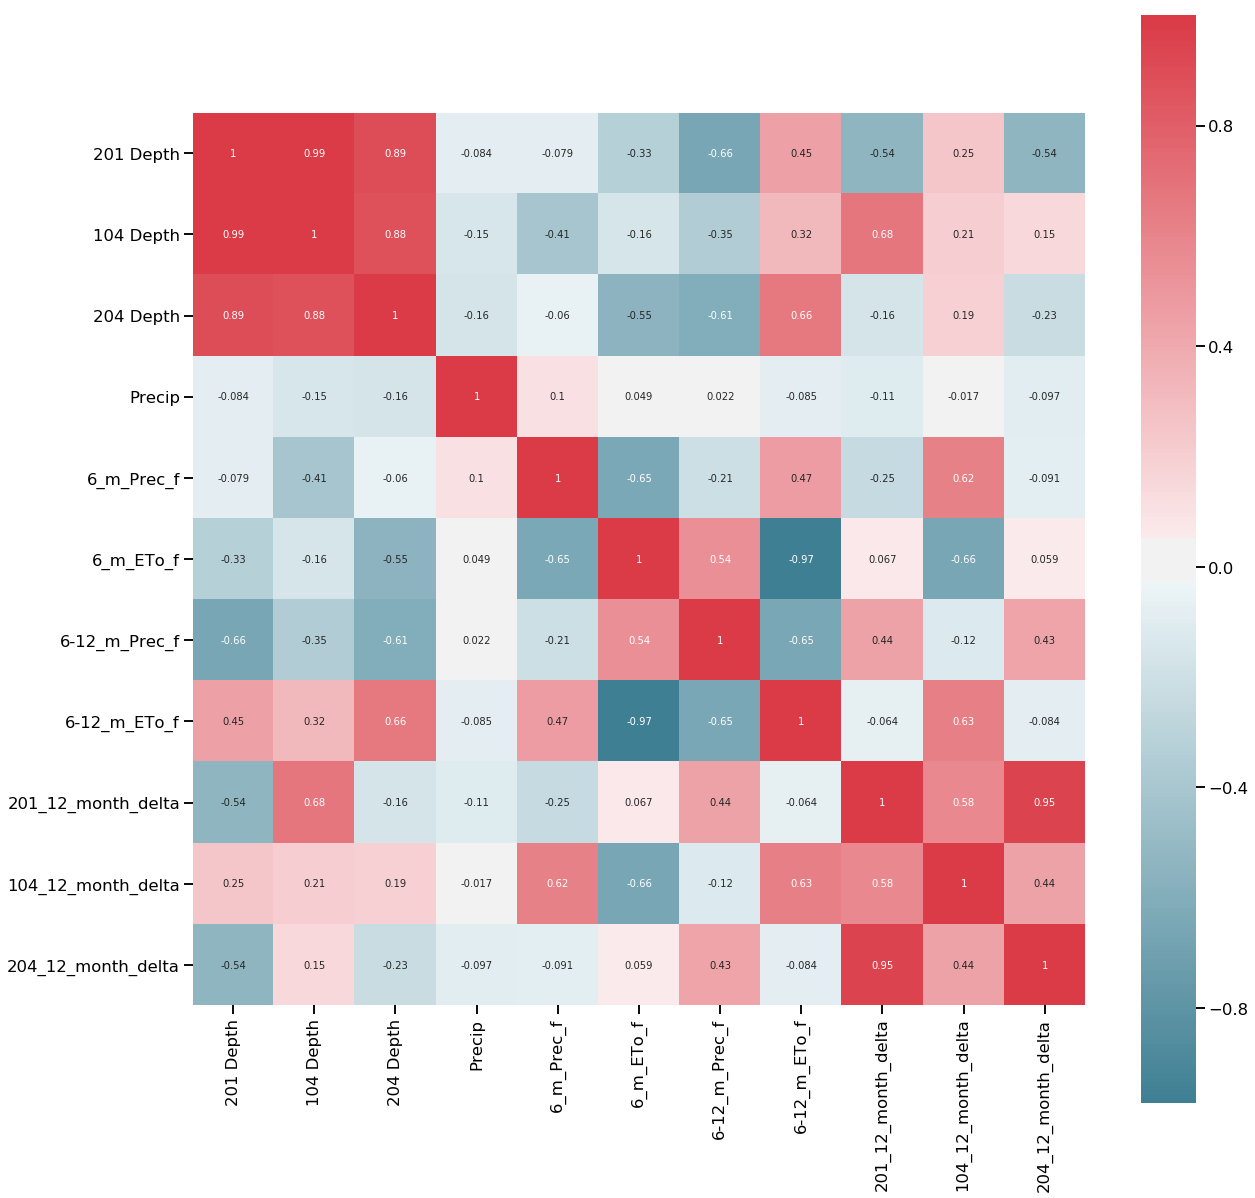

In [42]:
f, ax = plt.subplots(figsize=(20,20))
corr = df_c_w.corr()
sns.heatmap(corr, annot=True, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

**Underground water can take several months to infiltrate through the soil and reach the layer of the ground that is saturated with water, so the precipitation that happened during a previous period of time is also important. I am going to explore with different periods of time to find the period with the highest correlation. Same for ETo.**

In [43]:
df_c_w['2_m_Prec'] = df_c_w['Precip'].rolling(min_periods=61, window=61).sum()
df_c_w['2_m_ETo'] = df_c_w['ETo'].rolling(min_periods=61, window=61).sum()
df_c_w['4_m_Prec'] = df_c_w['Precip'].rolling(min_periods=122, window=122).sum()
df_c_w['4_m_ETo'] = df_c_w['ETo'].rolling(min_periods=122, window=122).sum()
df_c_w['6_m_Prec'] = df_c_w['Precip'].rolling(min_periods=182, window=182).sum()
df_c_w['6_m_ETo'] = df_c_w['ETo'].rolling(min_periods=182, window=182).sum()
df_c_w['8_m_Prec'] = df_c_w['Precip'].rolling(min_periods=243, window=243).sum()
df_c_w['8_m_ETo'] = df_c_w['ETo'].rolling(min_periods=243, window=243).sum()
df_c_w['10_m_Prec'] = df_c_w['Precip'].rolling(min_periods=304, window=304).sum()
df_c_w['10_m_ETo'] = df_c_w['ETo'].rolling(min_periods=304, window=304).sum()

In [44]:
Correlation = df_c_w.loc[:, (df_c_w.columns).isin(['201_12_month_delta', '204_12_month_delta','104_12_month_delta','2_m_Prec','2_m_ETo','4_m_Prec','4_m_ETo','6_m_Prec','6_m_ETo','8_m_Prec','8_m_ETo','10_m_Prec', '10_m_ETo'])]

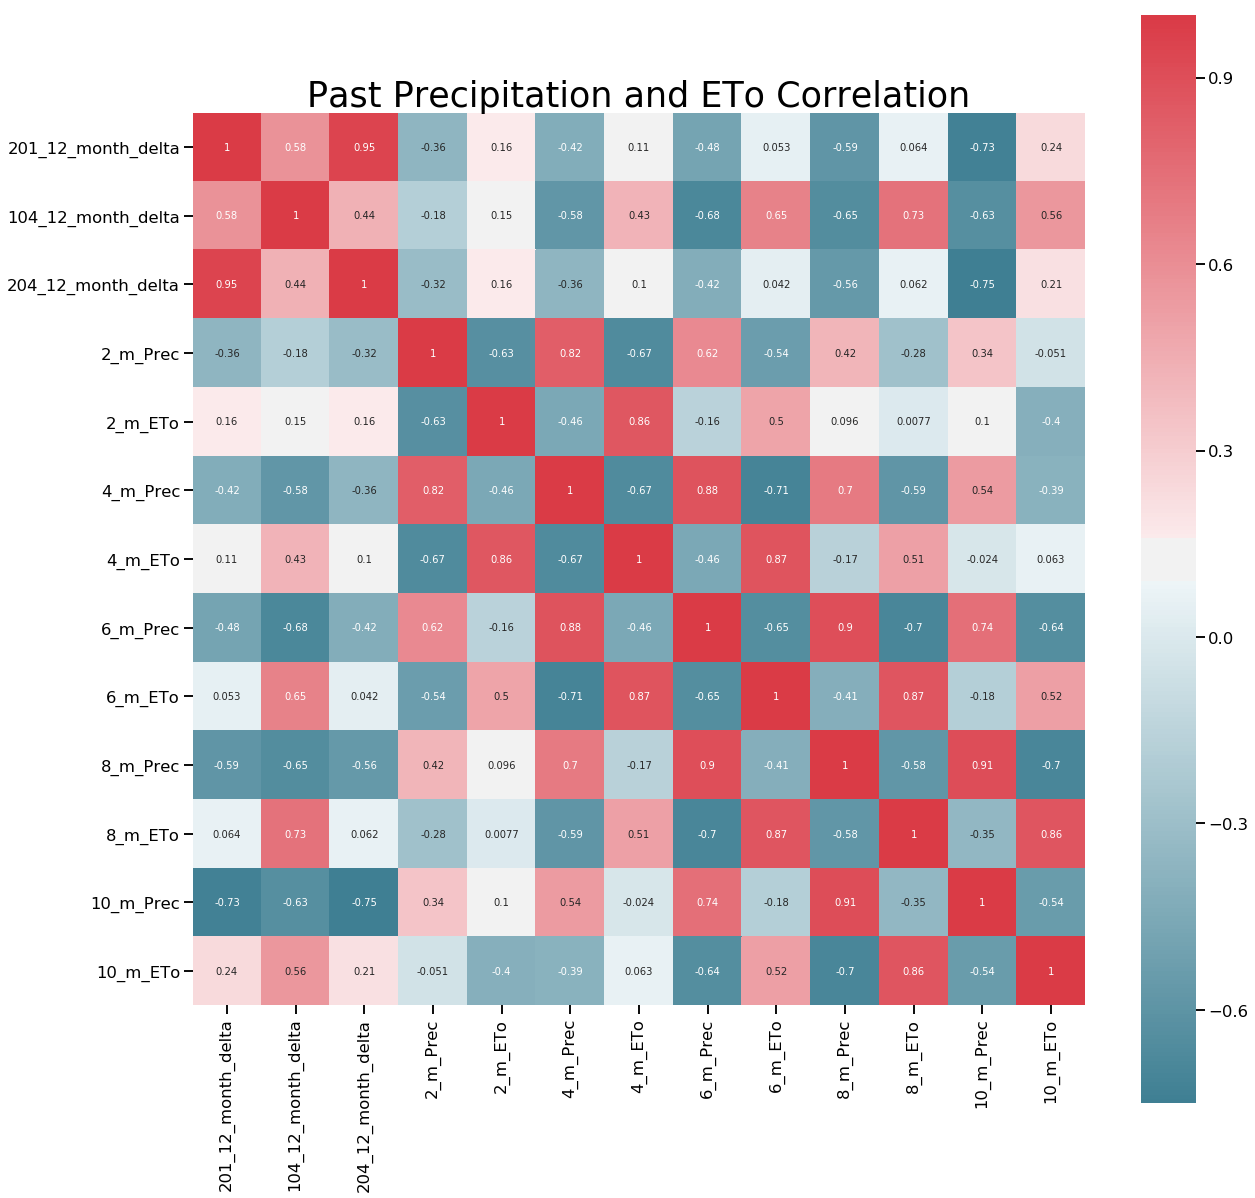

In [119]:
f, ax = plt.subplots(figsize=(20,20))
corr = Correlation.corr()
sns.heatmap(corr, annot=True, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Past Precipitation and ETo Corr',fontsize=35)
f.savefig('Past rain.png', bbox_inches = "tight")

plt.show()

**Looking at the chart above, I am going to use 10 m Precipitation data and 10 months of ETo data**

In [46]:
df_c_w = df_c_w.drop(['2_m_Prec', '2_m_ETo','4_m_Prec','6_m_Prec','4_m_ETo','6_m_ETo','8_m_ETo','8_m_Prec'], axis=1)

In [47]:
df_c_w.sample(5)

,201 Depth,104 Depth,204 Depth,Precip,ETo,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,201_12_month_delta,104_12_month_delta,204_12_month_delta,10_m_Prec,10_m_ETo
2010-02-08,473.63,NaN,384.13,0,1.015,196.0,945.126817,471.0,588.138963,-4.54,NaN,-3.78,378.0,1387.670027
2011-02-08,478.17,568.84,387.91,0,2.538,393.0,919.305000,116.0,609.408000,-12.77,-11.42,-14.41,551.0,1354.072780
2014-10-20,NaN,NaN,NaN,0,0.254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.0,1557.196990
2011-11-09,495.55,584.74,412.76,0,2.792,258.0,520.832000,0.0,1088.327000,NaN,NaN,-12.34,428.0,1417.280000
2010-05-16,472.85,NaN,390.67,0,7.868,79.0,1034.720817,750.0,496.008963,-7.31,NaN,-5.58,568.0,1135.808000


## Forecasting the depth of water

**I am going to compare two ways of predicting the water level, Time series and Machine Learning model and then select the better model**

## Machine Learning model

In [48]:
X = df_c_w.loc[:, ~(df_c_w.columns).isin(['201 Depth','204 Depth','104 Depth','Precip','ETo','201_12_month_delta','204_12_month_delta','104_12_month_delta'])]
y = df_c_w.loc[:, (df_c_w.columns).isin(['204_12_month_delta'])]

In [49]:
X.sample(5)

,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,10_m_Prec,10_m_ETo
2009-03-19,17.0,1125.479027,477.0,453.819000,NaN,NaN
2008-11-03,262.0,506.360000,46.0,1098.574027,NaN,NaN
2012-09-13,221.0,475.647000,12.0,1148.769547,238.0,1378.700000
2012-06-09,68.0,940.363000,164.0,676.915000,288.0,1154.594000
2013-09-30,125.0,516.040169,23.0,1174.250174,187.0,1437.568242


In [50]:
# I don't have delta data for all time series, so I am going to selecting just the ones with data
y[342:1183]


,204_12_month_delta
2009-08-09,0.33
2009-08-10,0.24
2009-08-11,-0.06
2009-08-12,-0.51
2009-08-13,-0.69
2009-08-14,0.18
2009-08-15,0.35
2009-08-16,0.28
2009-08-17,0.30
2009-08-18,0.22


In [51]:
X.isna().sum()

6_m_Prec_f       181
6_m_ETo_f        181
6-12_m_Prec_f    363
6-12_m_ETo_f     363
10_m_Prec        303
10_m_ETo         303
dtype: int64

In [52]:
X[342:1183]

,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,10_m_Prec,10_m_ETo
2009-08-09,370.0,600.521,201.0,939.542817,276.0,1268.383027
2009-08-10,375.0,595.698,196.0,945.126817,276.0,1270.921027
2009-08-11,375.0,589.860,196.0,950.710817,276.0,1274.474027
2009-08-12,381.0,583.515,190.0,957.055817,276.0,1278.281027
2009-08-13,389.0,577.932,182.0,961.877817,276.0,1281.834027
2009-08-14,389.0,572.603,182.0,966.445817,276.0,1284.118027
2009-08-15,389.0,568.796,182.0,970.506817,276.0,1286.148027
2009-08-16,389.0,564.735,182.0,974.567817,276.0,1288.432027
2009-08-17,389.0,560.674,182.0,978.882817,276.0,1290.716027
2009-08-18,389.0,556.867,182.0,982.943817,276.0,1293.508027


In [53]:
y, X = y[342:1183], X[342:1183]

In [54]:
#I am getting an error, so I am going to be sure everything is numeric
X = X.apply(pd.to_numeric)


In [55]:
from sklearn.model_selection import train_test_split

In [56]:
#splitting the data into test and train
X_train_r, X_test_r, y_train_r,  y_test_r = train_test_split(X, y, random_state=42, test_size=0.2)

In [57]:
clf = GradientBoostingRegressor()
from sklearn.metrics import make_scorer, explained_variance_score
from sklearn.model_selection import GridSearchCV


parameters = {'n_estimators': [200,300,400], 
              'min_samples_split':[4,5,6,7], 
              'max_depth':[3,4,5,6],
              'min_samples_leaf': [3,4,5,6],
              'learning_rate': [0.1,0.2]             }

acc_scorer = make_scorer(explained_variance_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer,n_jobs=4)
grid_obj = grid_obj.fit(X_train_r, y_train_r)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_



In [58]:
clf.fit(X_train_r, y_train_r)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=4,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
rfrscore = cross_val_score(clf, X_train_r, y_train_r, cv=5)
print (rfrscore)
print("rfrscore: %0.4f (+/- %0.4f)" % (rfrscore.mean(),rfrscore.std() * 2))

[0.99016969 0.99681421 0.99425464 0.99538739 0.99697368]
rfrscore: 0.9947 (+/- 0.0050)


In [60]:
predicted = clf.predict(X_test_r)
predict_df = pd.DataFrame(data = predicted, columns= ['prediction'])
predict_df['actual'] = y_test_r.values.ravel()
residual = predict_df['actual']- predict_df['prediction']

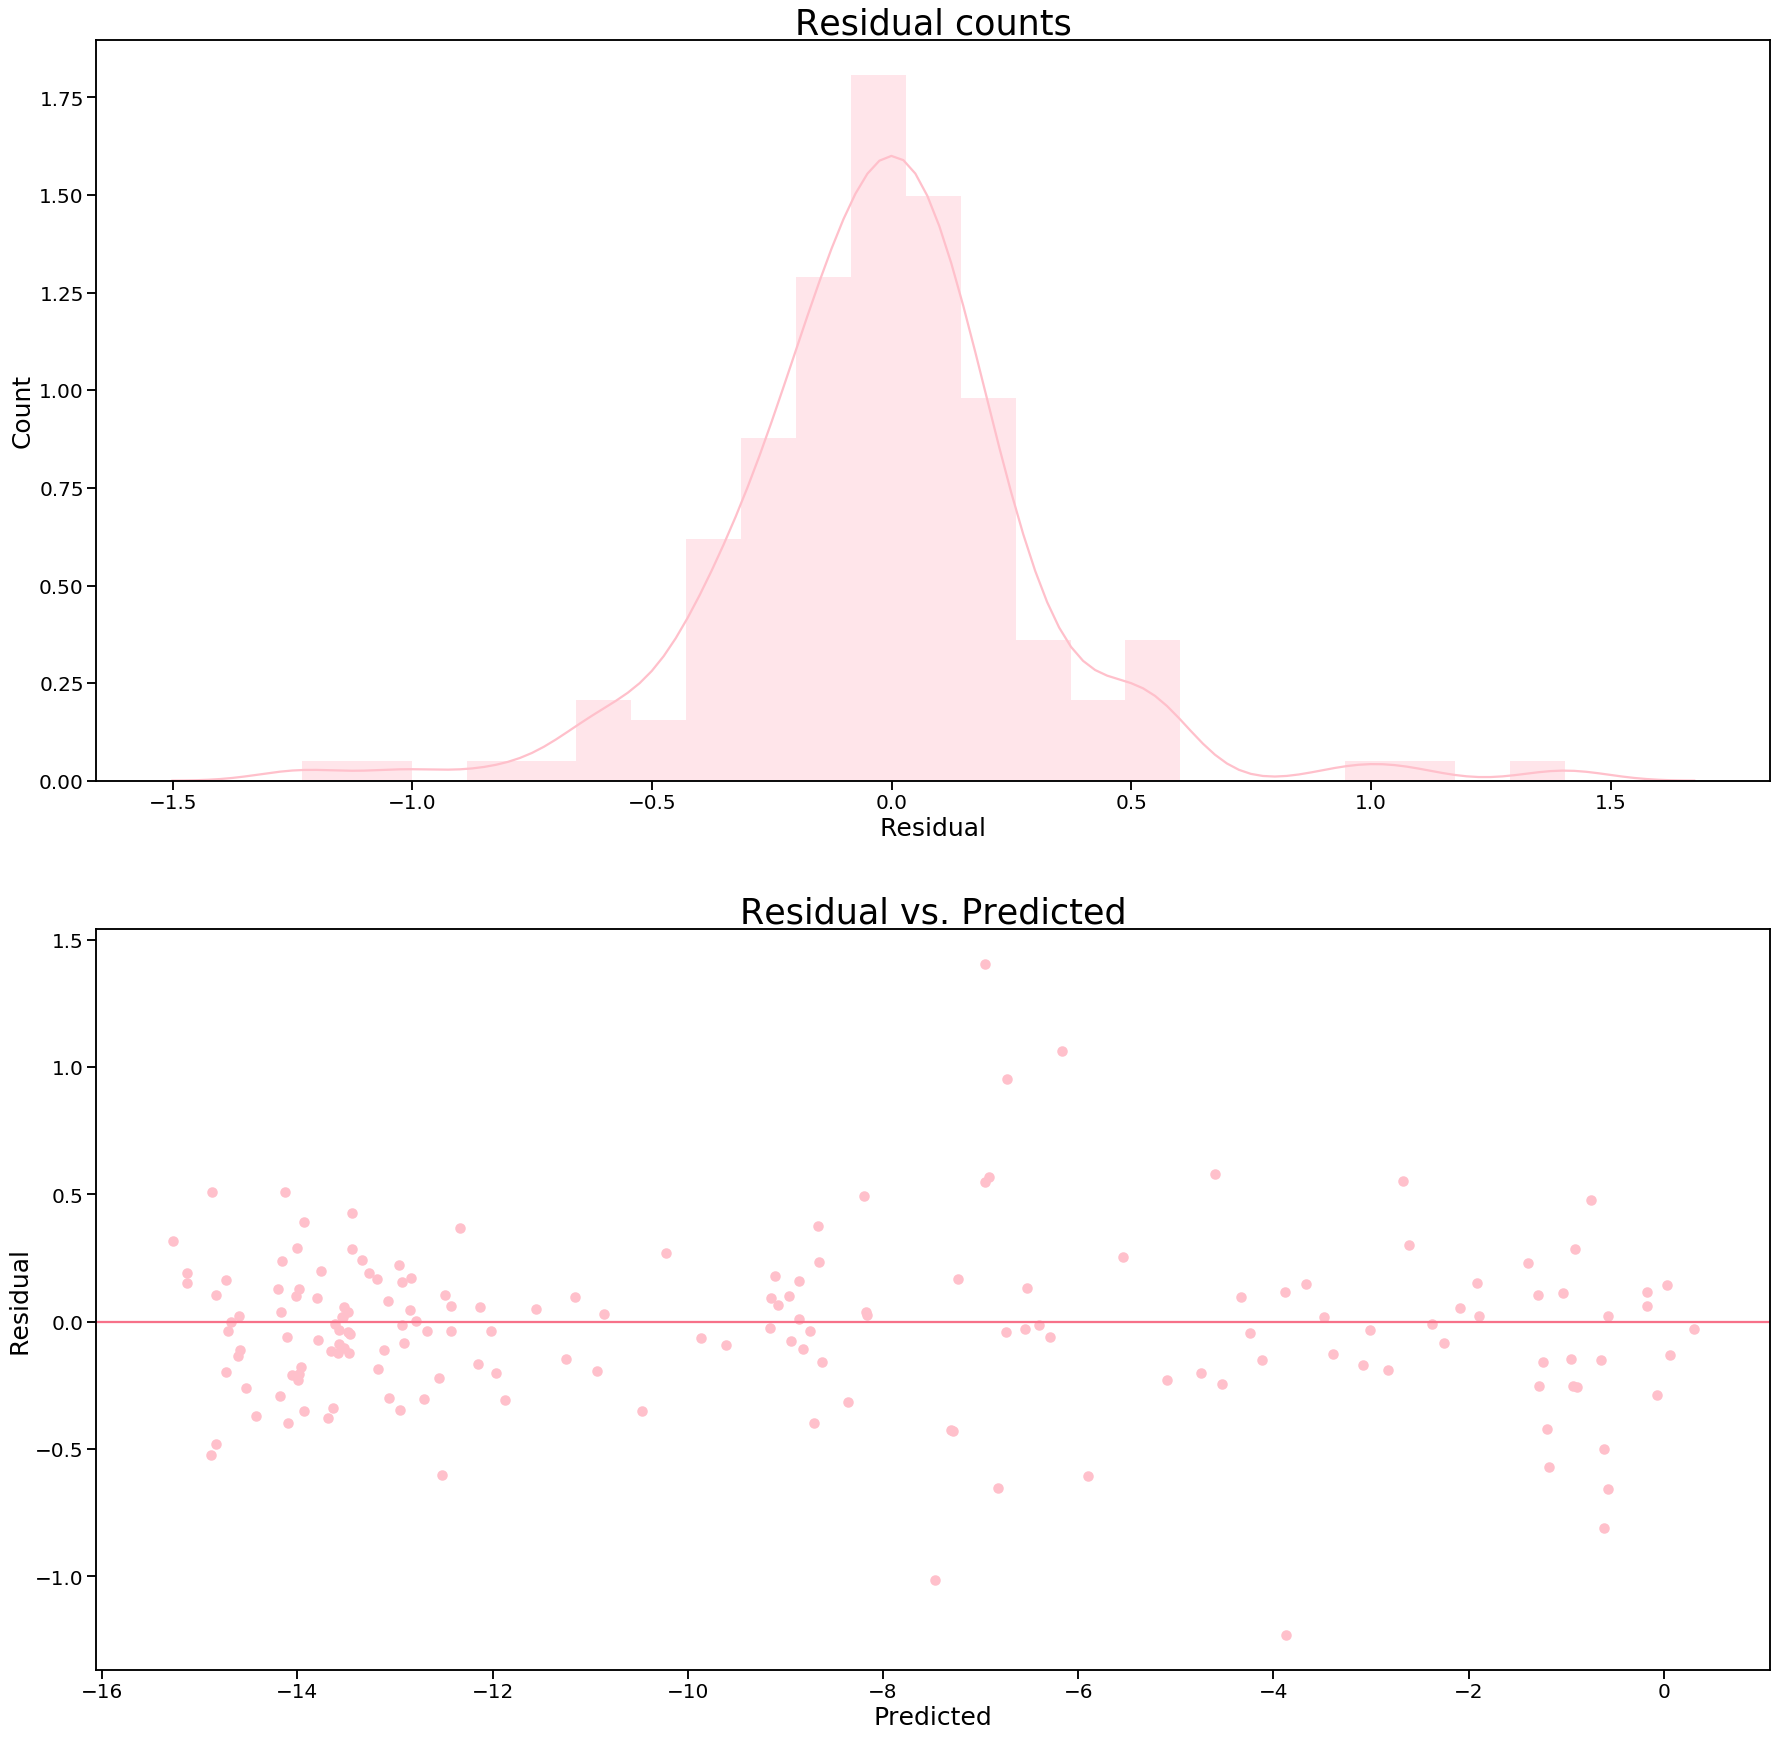

In [61]:
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)
fig.savefig('regresion1.png', bbox_inches = "tight")

plt.show()

In [62]:
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=4,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

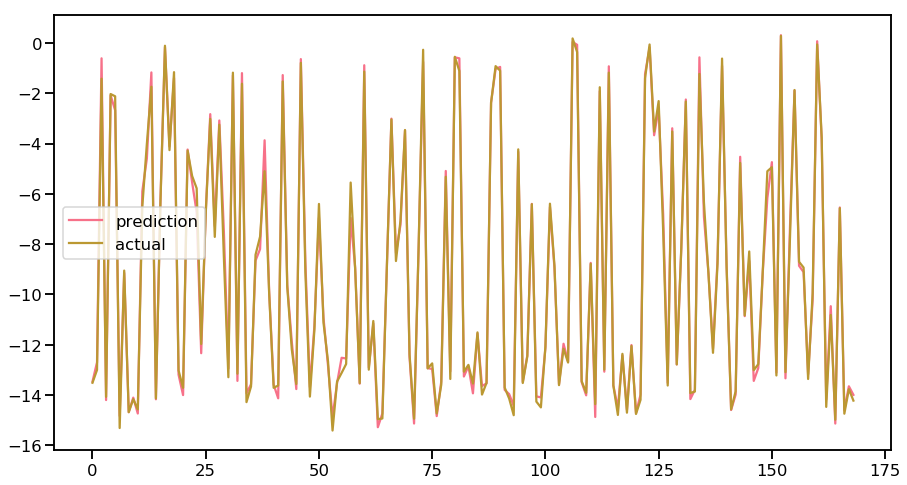

In [63]:
f, ax= plt.subplots(figsize=(15, 8))
predict_df.plot( y=0, ax=ax)
predict_df.plot( y=1, ax=ax)


plt.show()

**I don't have daily data after the summer of 2012, but I was able to find some measures for the following year, that allow me to test my data against the depth in those months ahead.**

In [74]:
# I am going to get the data for one year before the sampes I have, 2012-11-27, 2013-03-21...
X_test= df_c_w.loc['2011-11-27':'2011-11-27']
X_test= X_test.append(df_c_w.loc['2012-03-21':'2012-03-21'])
X_test= X_test.append(df_c_w.loc['2012-05-30':'2012-05-30'])
X_test= X_test.append(df_c_w.loc['2012-11-21':'2012-11-21'])


In [75]:
X_test

,201 Depth,104 Depth,204 Depth,Precip,ETo,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,201_12_month_delta,104_12_month_delta,204_12_month_delta,10_m_Prec,10_m_ETo
2011-11-27,494.39,583.69,409.69,0,2.284,211.0,606.110,19.0,1007.621000,NaN,NaN,-12.91,475.0,1413.220
2012-03-21,490.68,580.23,402.86,0,4.061,103.0,1120.563,221.0,465.496000,NaN,NaN,NaN,199.0,1269.822
2012-05-30,494.17,584.85,414.54,0,6.853,19.0,994.169,213.0,619.810000,NaN,NaN,NaN,288.0,1154.848
2012-11-21,NaN,NaN,423.43,0,2.031,213.0,591.131,3.0,1031.467242,NaN,NaN,NaN,203.0,1495.193


In [66]:
X1 = X_test.loc[:, (X_test.columns).isin(['6_m_Prec_f','6_m_ETo_f','6-12_m_Prec_f','6-12_m_ETo_f','10_m_ETo','10_m_Prec'])]


In [67]:
X1

,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,10_m_Prec,10_m_ETo
2011-11-27,211.0,606.110,19.0,1007.621000,475.0,1413.220
2012-03-21,103.0,1120.563,221.0,465.496000,199.0,1269.822
2012-05-30,19.0,994.169,213.0,619.810000,288.0,1154.848
2012-11-21,213.0,591.131,3.0,1031.467242,203.0,1495.193


In [68]:
predicted1 = clf.predict(X1)


In [71]:
predicted1

[-12.88040851, -15.17868374, -13.46899729, -13.05485874]

In [76]:
X_test['predicted_delta'] = predicted1
X_test['predicted_depth'] = X_test['204 Depth'] - X_test['predicted_delta']
X_test['actual_depth'] = [422.52, 416.30, 424.41, 430.97]

In [77]:
X_test

,201 Depth,104 Depth,204 Depth,Precip,ETo,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,201_12_month_delta,104_12_month_delta,204_12_month_delta,10_m_Prec,10_m_ETo,predicted_delta,predicted_depth,actual_depth
2011-11-27,494.39,583.69,409.69,0,2.284,211.0,606.110,19.0,1007.621000,NaN,NaN,-12.91,475.0,1413.220,-12.880409,422.570409,422.52
2012-03-21,490.68,580.23,402.86,0,4.061,103.0,1120.563,221.0,465.496000,NaN,NaN,NaN,199.0,1269.822,-15.178684,418.038684,416.30
2012-05-30,494.17,584.85,414.54,0,6.853,19.0,994.169,213.0,619.810000,NaN,NaN,NaN,288.0,1154.848,-13.468997,428.008997,424.41
2012-11-21,NaN,NaN,423.43,0,2.031,213.0,591.131,3.0,1031.467242,NaN,NaN,NaN,203.0,1495.193,-13.054859,436.484859,430.97


In [79]:
from sklearn.metrics import mean_squared_error

In [112]:
print("Date,  ", "Previous Year,", "Forecast,", "   Actual Value")
print('2012-11-27', 409.69,'>', 409.69--12.88,'>', 422.52)
print('2013-03-21', 402.86,'>', 402.86--15.18,'>',  416.30)
print('2013-05-30',414.54,'>', 414.54--13.47, '>', 424.41)
print('2013-11-21',423.43,'>', 423.43--13.06, '>', 430.97)
print("mean_squared_error", mean_squared_error(X_test['actual_depth'],X_test['predicted_depth']))

Date,   Previous Year, Forecast,    Actual Value
2012-11-27 409.69 > 422.57 > 422.52
2013-03-21 402.86 > 418.04 > 416.3
2013-05-30 414.54 > 428.01000000000005 > 424.41
2013-11-21 423.43 > 436.49 > 430.97
mean_squared_error 11.59800264530054


**I am also going to test Random Forest to see what algorithm provides a better forecast.**

In [81]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestRegressor(n_estimators=300)


rfc.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [82]:
predicted_rfc = rfc.predict(X1)


In [86]:
predicted_rfc

[-12.898, -15.39883333, -13.99355152, -12.91053333]

In [87]:
X_test['predicted_delta2'] = predicted_rfc
X_test['predicted_depth2'] = X_test['204 Depth'] - X_test['predicted_delta2']

In [88]:
print("Date,  ", "Previous Year,", "Forecast,", "   Actual Value")
print('2012-11-27', 409.69, '>',409.69--12.90,'>', 422.52)
print('2013-03-21' , 402.86, '>',402.86--15.40,'>',  416.30)
print('2013-05-30' ,414.54,'>', 414.54--13.99, '>', 424.41)
print('2013-11-21' ,423.43, '>',423.43--12.91, '>', 430.97)
print("mean_squared_error", mean_squared_error(X_test['actual_depth'],X_test['predicted_depth2']))

Date,   Previous Year, Forecast,    Actual Value
2012-11-27 409.69 > 422.59 > 422.52
2013-03-21 402.86 > 418.26 > 416.3
2013-05-30 414.54 > 428.53000000000003 > 424.41
2013-11-21 423.43 > 436.34000000000003 > 430.97
mean_squared_error 12.421989350363486


**Given the results above, Gradient Boosting model does a better job of forecasting the depth values than Random Forest.**

In [89]:
print ("Features sorted by their score:")
names = X.columns.values

feature_imp = (sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
             reverse=True))
print(feature_imp)

Features sorted by their score:
[(0.6108, '10_m_Prec'), (0.3266, '6-12_m_Prec_f'), (0.0231, '6-12_m_ETo_f'), (0.0218, '10_m_ETo'), (0.0105, '6_m_ETo_f'), (0.0071, '6_m_Prec_f')]


**The main feature used to predict the value is the amount of precipitation between 6 months and 12 months in the feature,  followed by the amount of ETo for the same period.**

# Time Series

In [120]:
y = df_c_w.loc[:, (df_c_w.columns).isin(['204_12_month_delta'])]

In [121]:
y[242:1183]

,204_12_month_delta
2009-05-01,0.95
2009-05-02,1.22
2009-05-03,0.78
2009-05-04,-1.06
2009-05-05,-0.68
2009-05-06,-1.06
2009-05-07,-1.17
2009-05-08,-1.57
2009-05-09,-0.12
2009-05-10,-1.04


In [122]:
df_time_series = y[242:1183]

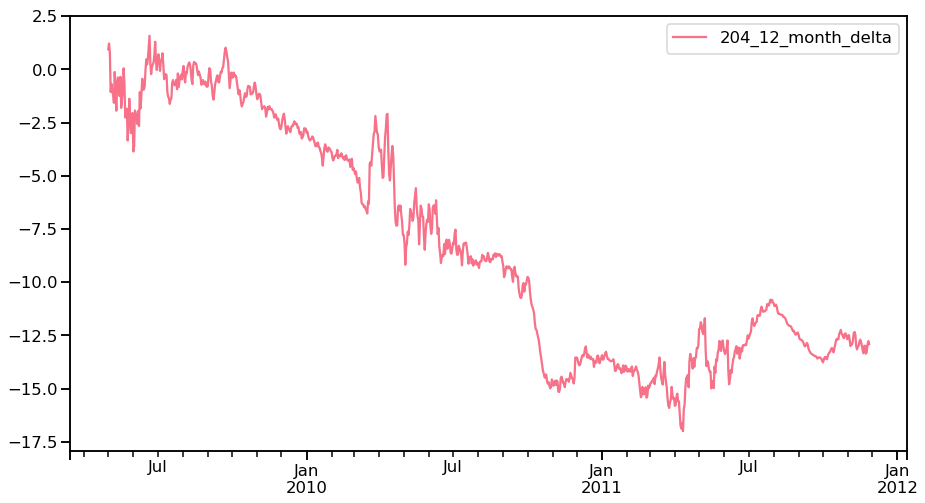

In [123]:
f, ax= plt.subplots(figsize=(15, 8))
df_time_series.plot( y=0, ax=ax)

plt.show()

In [124]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    plt.figure(figsize=(12,8))
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


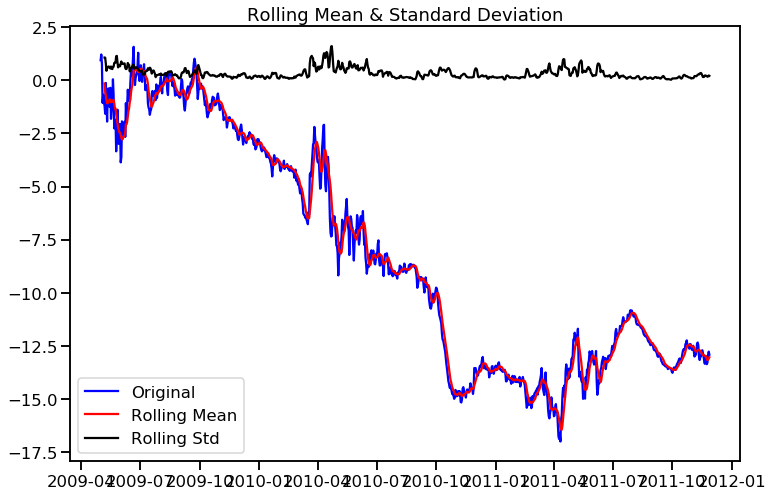

In [125]:
test_stationarity(df_time_series)


Text(0.5, 1.0, 'Page Views PACF')

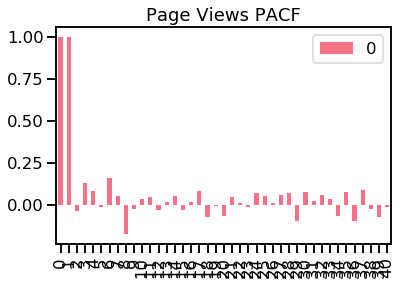

In [96]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(df_time_series))
x_acf.plot(kind='bar')
plt.title("Page Views PACF")

**Based on the chart above, the time series has 1 strong autocorrelation**

**I am going to build a series of models to evaluate, each with slightly different parameters for the ARIMA.**

                              ARMA Model Results                              
Dep. Variable:     204_12_month_delta   No. Observations:                  941
Model:                     ARMA(1, 0)   Log Likelihood                -404.114
Method:                       css-mle   S.D. of innovations              0.371
Date:                Sun, 10 Mar 2019   AIC                            814.227
Time:                        00:34:24   BIC                            828.768
Sample:                    05-01-2009   HQIC                           819.770
                         - 11-27-2011                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -7.0377      4.484     -1.569      0.117     -15.826       1.751
ar.L1.204_12_month_delta     0.9981      0.002    588.269      0.000       0.995       1.

Text(0.5, 1.0, 'Histogram of Residuals')

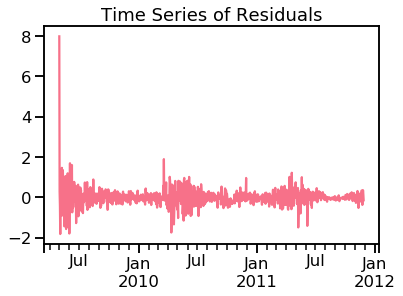

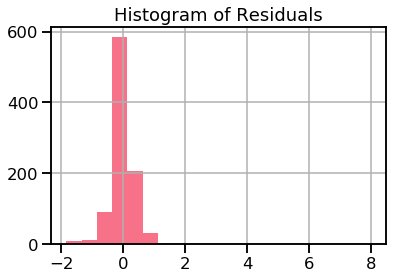

In [97]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_time_series, order=(1,0,0))
model_fit100 = model.fit()
print(model_fit100.summary())
print('Residuals Description')
print(model_fit100.resid.describe())

residuals = pd.DataFrame(model_fit100.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

                              ARIMA Model Results                               
Dep. Variable:     D.204_12_month_delta   No. Observations:                  940
Model:                   ARIMA(0, 1, 0)   Log Likelihood                -400.498
Method:                             css   S.D. of innovations              0.371
Date:                  Sun, 10 Mar 2019   AIC                            804.996
Time:                          00:34:24   BIC                            814.688
Sample:                      05-02-2009   HQIC                           808.691
                           - 11-27-2011                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0147      0.012     -1.220      0.223      -0.038       0.009
Residuals Description
count    9.400000e+02
mean     2.961220e-10
std      3.707066e-01
min     -1.825255e+00
25%  

Text(0.5, 1.0, 'Histogram of Residuals')

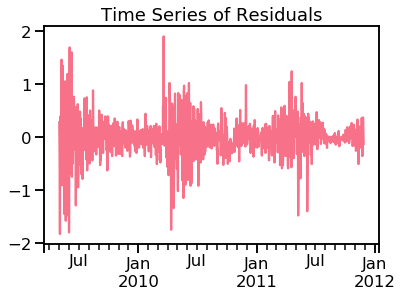

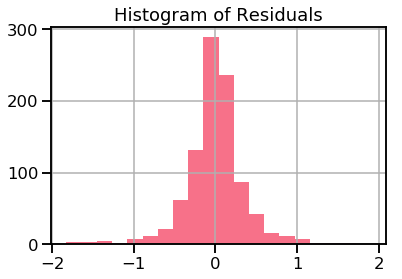

In [98]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_time_series, order=(0,1,0))
model_fit010 = model.fit()
print(model_fit010.summary())
print('Residuals Description')
print(model_fit010.resid.describe())

residuals = pd.DataFrame(model_fit010.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

                              ARMA Model Results                              
Dep. Variable:     204_12_month_delta   No. Observations:                  941
Model:                     ARMA(1, 1)   Log Likelihood                -403.389
Method:                       css-mle   S.D. of innovations              0.370
Date:                Sun, 10 Mar 2019   AIC                            814.778
Time:                        13:35:32   BIC                            834.166
Sample:                    05-01-2009   HQIC                           822.169
                         - 11-27-2011                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -7.1026      4.342     -1.636      0.102     -15.612       1.407
ar.L1.204_12_month_delta     0.9979      0.002    545.434      0.000       0.994       1.

<Figure size 2160x2160 with 0 Axes>

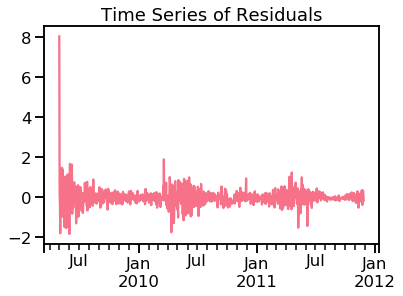

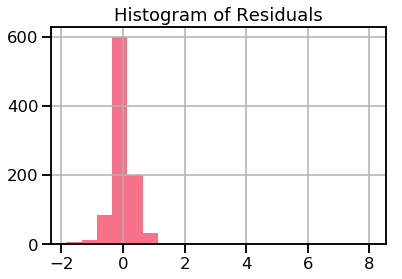

In [133]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_time_series, order=(1,0,1))
model_fit010 = model.fit()
print(model_fit010.summary())
print('Residuals Description')
print(model_fit010.resid.describe())

residuals = pd.DataFrame(model_fit010.resid)

fig = plt.figure(figsize=(30,30))

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')
fig.savefig('time_series', bbox_inches = "tight")


plt.show()

                              ARIMA Model Results                               
Dep. Variable:     D.204_12_month_delta   No. Observations:                  940
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -391.523
Method:                         css-mle   S.D. of innovations              0.367
Date:                  Sun, 10 Mar 2019   AIC                            791.046
Time:                          13:29:37   BIC                            810.429
Sample:                      05-02-2009   HQIC                           798.435
                           - 11-27-2011                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.0148      0.013     -1.180      0.238      -0.039       0.010
ar.L1.D.204_12_month_delta    -0.7821      0.055    -14.279      0.

Text(0.5, 1.0, 'Histogram of Residuals')

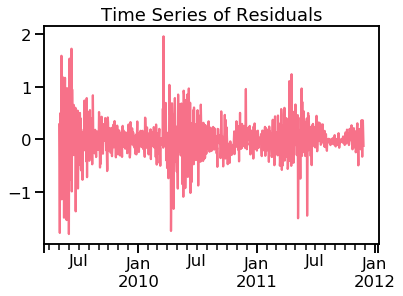

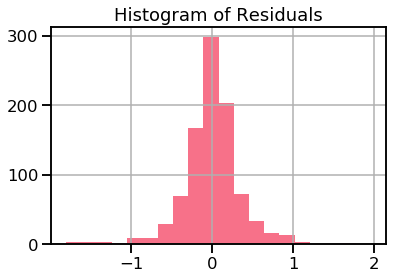

In [126]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_time_series, order=(1,1,1))
model_fit111 = model.fit()
print(model_fit111.summary())
print('Residuals Description')
print(model_fit111.resid.describe())

residuals = pd.DataFrame(model_fit111.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

**Of the four models tested, it seems like the one that explains the variance better is the ARIMA(1,1,1)
It has the lowest value of Log Likelihood and AIC. Also, the distribution of the residuals seems to be more random of all of them. Also, the residuals seem more standard normal than the rest.**

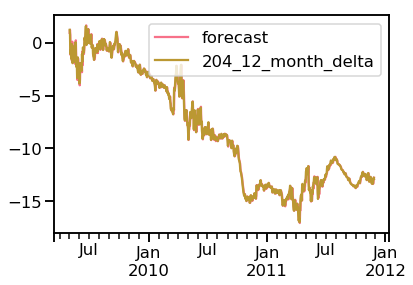

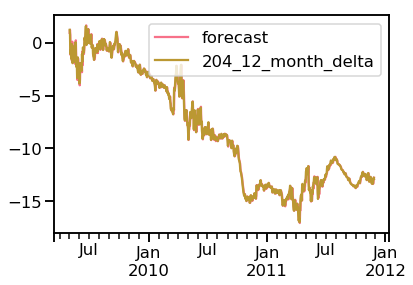

In [101]:
model_fit111.plot_predict(1) 


In [103]:
#I am going to calculate the forecast for the next 365 days. 
one_year_step = model_fit111.forecast(steps=365)


In [104]:
one_year_step[0]

array([-12.93337802, -12.94149735, -12.96155021, -12.97227008,
       -12.9902891 , -13.00259959, -13.01937462, -13.03265802,
       -13.04867215, -13.06255063, -13.07809937, -13.09234183,
       -13.1076059 , -13.12207099, -13.13716095, -13.15176221,
       -13.16674567, -13.18143022, -13.19634854, -13.21108404,
       -13.22596252, -13.24072917, -13.25558328, -13.27036899,
       -13.2852082 , -13.30000557, -13.31483565, -13.32964015,
       -13.34446467, -13.35927353, -13.37409463, -13.38890616,
       -13.40372517, -13.41853833, -13.43335607, -13.44817023,
       -13.46298719, -13.47780195, -13.49261844, -13.50743358,
       -13.52224977, -13.53706514, -13.55188115, -13.56669666,
       -13.58151256, -13.59632815, -13.61114399, -13.62595963,
       -13.64077543, -13.65559111, -13.67040687, -13.68522257,
       -13.70003833, -13.71485404, -13.72966978, -13.7444855 ,
       -13.75930124, -13.77411696, -13.78893269, -13.80374842,
       -13.81856415, -13.83337988, -13.84819561, -13.86

**I am going to create a new DT with data from df_c_w for the dates covered by the Time Series forecast, and I am going to create a new column with the forecast from the TimeSeries**

In [105]:
TimeSeries204= df_c_w.loc['2011-11-27':'2012-11-25']

In [106]:
TimeSeries204['forecast'] = one_year_step[0]

In [107]:
TimeSeries204.head(5)

,201 Depth,104 Depth,204 Depth,Precip,ETo,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,201_12_month_delta,104_12_month_delta,204_12_month_delta,10_m_Prec,10_m_ETo,forecast
2011-11-27,494.39,583.69,409.69,0,2.284,211.0,606.110,19.0,1007.621,NaN,NaN,-12.91,475.0,1413.220,-12.933378
2011-11-28,494.20,583.51,409.41,0,2.538,211.0,609.917,19.0,1004.068,NaN,NaN,NaN,475.0,1413.220,-12.941497
2011-11-29,494.06,583.39,408.62,0,2.538,211.0,613.724,19.0,1000.007,NaN,NaN,NaN,475.0,1413.220,-12.961550
2011-11-30,493.88,583.22,408.62,0,2.284,211.0,618.039,19.0,994.169,NaN,NaN,NaN,471.0,1414.235,-12.972270
2011-12-01,493.75,583.15,408.27,0,2.538,211.0,622.608,23.0,988.585,NaN,NaN,NaN,470.0,1414.996,-12.990289


In [108]:
Ts_test= TimeSeries204.loc['2011-11-27':'2011-11-27']
Ts_test= Ts_test.append(TimeSeries204.loc['2012-03-21':'2012-03-21'])
Ts_test= Ts_test.append(TimeSeries204.loc['2012-05-30':'2012-05-30'])
Ts_test= Ts_test.append(TimeSeries204.loc['2012-11-21':'2012-11-21'])

In [109]:
Ts_test

,201 Depth,104 Depth,204 Depth,Precip,ETo,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,201_12_month_delta,104_12_month_delta,204_12_month_delta,10_m_Prec,10_m_ETo,forecast
2011-11-27,494.39,583.69,409.69,0,2.284,211.0,606.110,19.0,1007.621000,NaN,NaN,-12.91,475.0,1413.220,-12.933378
2012-03-21,490.68,580.23,402.86,0,4.061,103.0,1120.563,221.0,465.496000,NaN,NaN,NaN,199.0,1269.822,-14.633429
2012-05-30,494.17,584.85,414.54,0,6.853,19.0,994.169,213.0,619.810000,NaN,NaN,NaN,288.0,1154.848,-15.670530
2012-11-21,NaN,NaN,423.43,0,2.031,213.0,591.131,3.0,1031.467242,NaN,NaN,NaN,203.0,1495.193,-18.263283


In [110]:
Ts_test['predicted_depth'] = Ts_test['204 Depth'] - Ts_test['forecast']

**Now I have the Time Series forecast for the 4 days that I also forecasted with the machine learning model. Now I can compare both models.**

In [111]:
print ("TIME SERIES MODEL PREDICTION")
print("Date,  ", "Previous Year,", "Forecast,", "   Actual Value")
print('2012-11-27', 409.66,'>',409.69--12.93,'>', 422.52)
print('2013-03-21', 402.86,'>', 402.86--14.63,'>',  416.30)
print('2013-05-30', 414.54,'>', 414.54--15.67, '>', 424.41)
print('2013-11-21' ,423.43, '>',423.43--18.26, '>', 430.97)
print("mean_squared_error", mean_squared_error(X_test['actual_depth'],Ts_test['predicted_depth']))

TIME SERIES MODEL PREDICTION
Date,   Previous Year, Forecast,    Actual Value
2012-11-27 409.66 > 422.62 > 422.52
2013-03-21 402.86 > 417.49 > 416.3
2013-05-30 414.54 > 430.21000000000004 > 424.41
2013-11-21 423.43 > 441.69 > 430.97
mean_squared_error 37.51747742602863


**Both models performed similarity for the first date. The time series model did better for the second date, but worse for the last two dates, especially for the last date. 
Comparing the mean square error, the machine learning model did a better job and I am going to use it to predict the other two wells** 

# Forecast for the two other wells.

## 201 Well

In [157]:
X = df_c_w.loc[:, ~(df_c_w.columns).isin(['201 Depth','204 Depth','104 Depth','Precip','ETo','201_12_month_delta','204_12_month_delta','104_12_month_delta'])]
y = df_c_w.loc[:, (df_c_w.columns).isin(['201_12_month_delta'])]


In [158]:
X.isna().sum()

6_m_Prec_f       181
6_m_ETo_f        181
6-12_m_Prec_f    363
6-12_m_ETo_f     363
10_m_Prec        303
10_m_ETo         303
dtype: int64

In [162]:
y, X = y[242:1020], X[242:1020]

In [163]:
X_train_r, X_test_r, y_train_r,  y_test_r = train_test_split(X, y, test_size=0.2)

In [164]:
clf = GradientBoostingRegressor()
from sklearn.metrics import make_scorer, explained_variance_score
from sklearn.model_selection import GridSearchCV


parameters = {'n_estimators': [200,300,400], 
              'min_samples_split':[4,5,6,7], 
              'max_depth':[3,4,5,6],
              'min_samples_leaf': [3,4,5,6],
              'learning_rate': [0.1,0.2]             }

acc_scorer = make_scorer(explained_variance_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer,n_jobs=4)
grid_obj = grid_obj.fit(X_train_r, y_train_r)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_



In [165]:
clf.fit(X_train_r, y_train_r)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [166]:
rfrscore = cross_val_score(clf, X_train_r, y_train_r, cv=5)
print (rfrscore)
print("rfrscore: %0.4f (+/- %0.4f)" % (rfrscore.mean(),rfrscore.std() * 2))

[0.99381051 0.96092574 0.99598174 0.99768098 0.99235104]
rfrscore: 0.9881 (+/- 0.0275)


In [167]:
predicted = clf.predict(X_test_r)
predict_df = pd.DataFrame(data = predicted, columns= ['prediction'])
predict_df['actual'] = y_test_r.values.ravel()
residual = predict_df['actual']- predict_df['prediction']

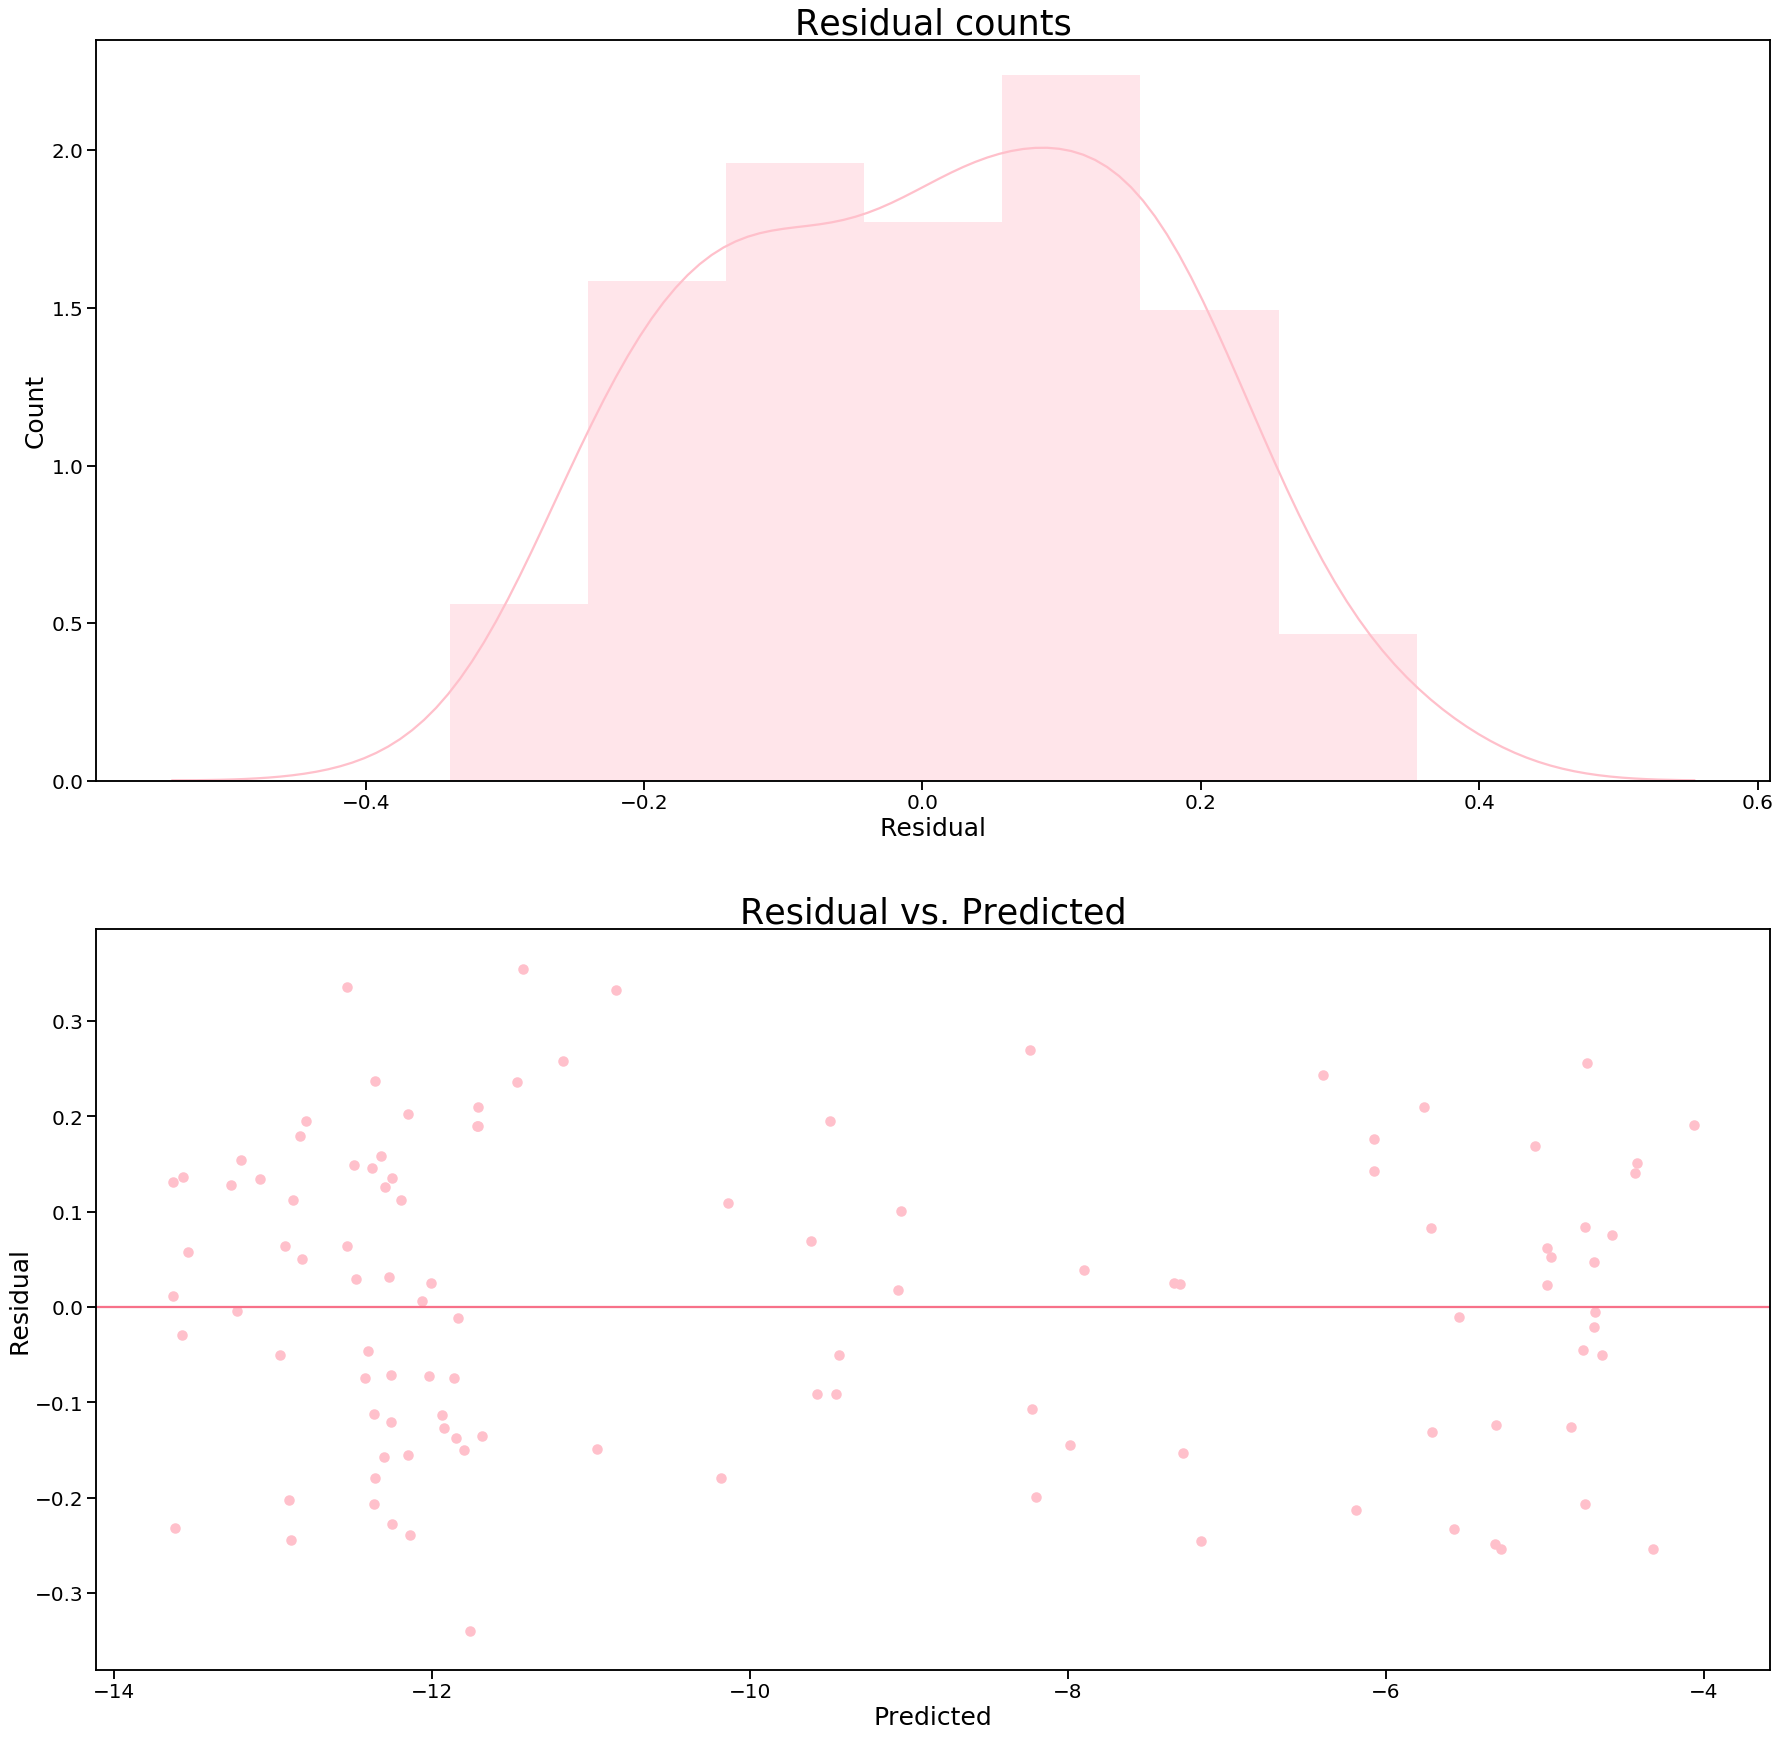

In [168]:
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)
fig.savefig('regresion1.png', bbox_inches = "tight")

plt.show()

In [169]:
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [170]:
X_test= df_c_w.loc['2011-08-16':'2011--08-16']
X_test= X_test.append(df_c_w.loc['2011-12-03':'2011-12-03'])
X_test= X_test.append(df_c_w.loc['2012-03-21':'2012-03-21'])
X_test= X_test.append(df_c_w.loc['2012-05-30':'2012-05-30'])


In [171]:
X_test

,201 Depth,104 Depth,204 Depth,Precip,ETo,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,201_12_month_delta,104_12_month_delta,204_12_month_delta,10_m_Prec,10_m_ETo
2011-08-16,492.90,581.56,415.090909,0,6.853,119.0,577.937,169.0,1010.158,-7.52,-8.72,-11.749091,841.0,1195.001963
2011-12-03,493.80,583.26,408.080000,0,1.777,211.0,633.268,46.0,977.925,NaN,NaN,NaN,470.0,1414.235000
2012-03-21,490.68,580.23,402.860000,0,4.061,103.0,1120.563,221.0,465.496,NaN,NaN,NaN,199.0,1269.822000
2012-05-30,494.17,584.85,414.540000,0,6.853,19.0,994.169,213.0,619.810,NaN,NaN,NaN,288.0,1154.848000


In [172]:
X1 = X_test.loc[:, (X_test.columns).isin(['6_m_Prec_f','6_m_ETo_f','6-12_m_Prec_f','6-12_m_ETo_f','10_m_Prec','10_m_ETo'])]


In [173]:
X1

,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,10_m_Prec,10_m_ETo
2011-08-16,119.0,577.937,169.0,1010.158,841.0,1195.001963
2011-12-03,211.0,633.268,46.0,977.925,470.0,1414.235000
2012-03-21,103.0,1120.563,221.0,465.496,199.0,1269.822000
2012-05-30,19.0,994.169,213.0,619.810,288.0,1154.848000


In [174]:
predicted2 = clf.predict(X1)
predicted2

array([-12.21406177, -12.41832876, -13.26983151, -12.58012396])

In [175]:
from sklearn.metrics import mean_squared_error

In [177]:
print("Date,  ", "Previous Year,", "Forecast,", " Actual Value")
print('2012-08-16', 492.90, '>',492.90--12.21,'>', 504.04)
print('2012-12-03' , 493.80, '>',493.80--12.41 ,'>',  504.40)
print('2013-03-21' ,490.68,'>', 490.68--13.27, '>', 501.65)
print('2013-05-30' ,494.17, '>',494.17--12.58, '>', 505.68)


Date,   Previous Year, Forecast,  Actual Value
2012-08-16 492.9 > 505.10999999999996 > 504.04
2012-12-03 493.8 > 506.21000000000004 > 504.4
2013-03-21 490.68 > 503.95 > 501.65
2013-05-30 494.17 > 506.75 > 505.68


In [178]:
print ("Features sorted by their score:")
names = X.columns.values

feature_imp = (sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
             reverse=True))
print(feature_imp)

Features sorted by their score:
[(0.84, '6-12_m_Prec_f'), (0.0985, '10_m_ETo'), (0.0326, '6_m_Prec_f'), (0.0169, '6-12_m_ETo_f'), (0.0081, '6_m_ETo_f'), (0.004, '10_m_Prec')]


**For well 201, the model does a good job of capturing the trend. Especially for the dates further in the future. Again, the main feature used by the model is the precipitation between 6 months and 12 months ahead.**

# 104 Well

In [135]:
X = df_c_w.loc[:, ~(df_c_w.columns).isin(['201 Depth','204 Depth','104 Depth','Precip','ETo','201_12_month_delta','204_12_month_delta','104_12_month_delta'])]
y = df_c_w.loc[:, (df_c_w.columns).isin(['104_12_month_delta'])]


In [136]:
y[689:1080]

,104_12_month_delta
2010-07-22,-10.21
2010-07-23,-10.30
2010-07-24,-10.43
2010-07-25,-10.44
2010-07-26,-10.33
2010-07-27,-10.24
2010-07-28,-10.21
2010-07-29,-10.22
2010-07-30,-10.31
2010-07-31,-10.37


In [137]:
y, X = y[689:1080], X[689:1080]

In [138]:
X_train_r, X_test_r, y_train_r,  y_test_r = train_test_split(X, y, test_size=0.2)

In [139]:
clf = GradientBoostingRegressor()
from sklearn.metrics import make_scorer, explained_variance_score
from sklearn.model_selection import GridSearchCV


parameters = {'n_estimators': [200,300,400], 
              'min_samples_split':[4,5,6,7], 
              'max_depth':[3,4,5,6],
              'min_samples_leaf': [3,4,5,6],
              'learning_rate': [0.1,0.2]             }

acc_scorer = make_scorer(explained_variance_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer,n_jobs=4)
grid_obj = grid_obj.fit(X_train_r, y_train_r)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_



In [140]:
clf.fit(X_train_r, y_train_r)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=7, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [141]:
rfrscore = cross_val_score(clf, X_train_r, y_train_r, cv=5)
print (rfrscore)
print("rfrscore: %0.4f (+/- %0.4f)" % (rfrscore.mean(),rfrscore.std() * 2))

[0.96328677 0.95876277 0.97154865 0.97145894 0.92755718]
rfrscore: 0.9585 (+/- 0.0325)


In [142]:
predicted = clf.predict(X_test_r)
predict_df = pd.DataFrame(data = predicted, columns= ['prediction'])
predict_df['actual'] = y_test_r.values.ravel()
residual = predict_df['actual']- predict_df['prediction']

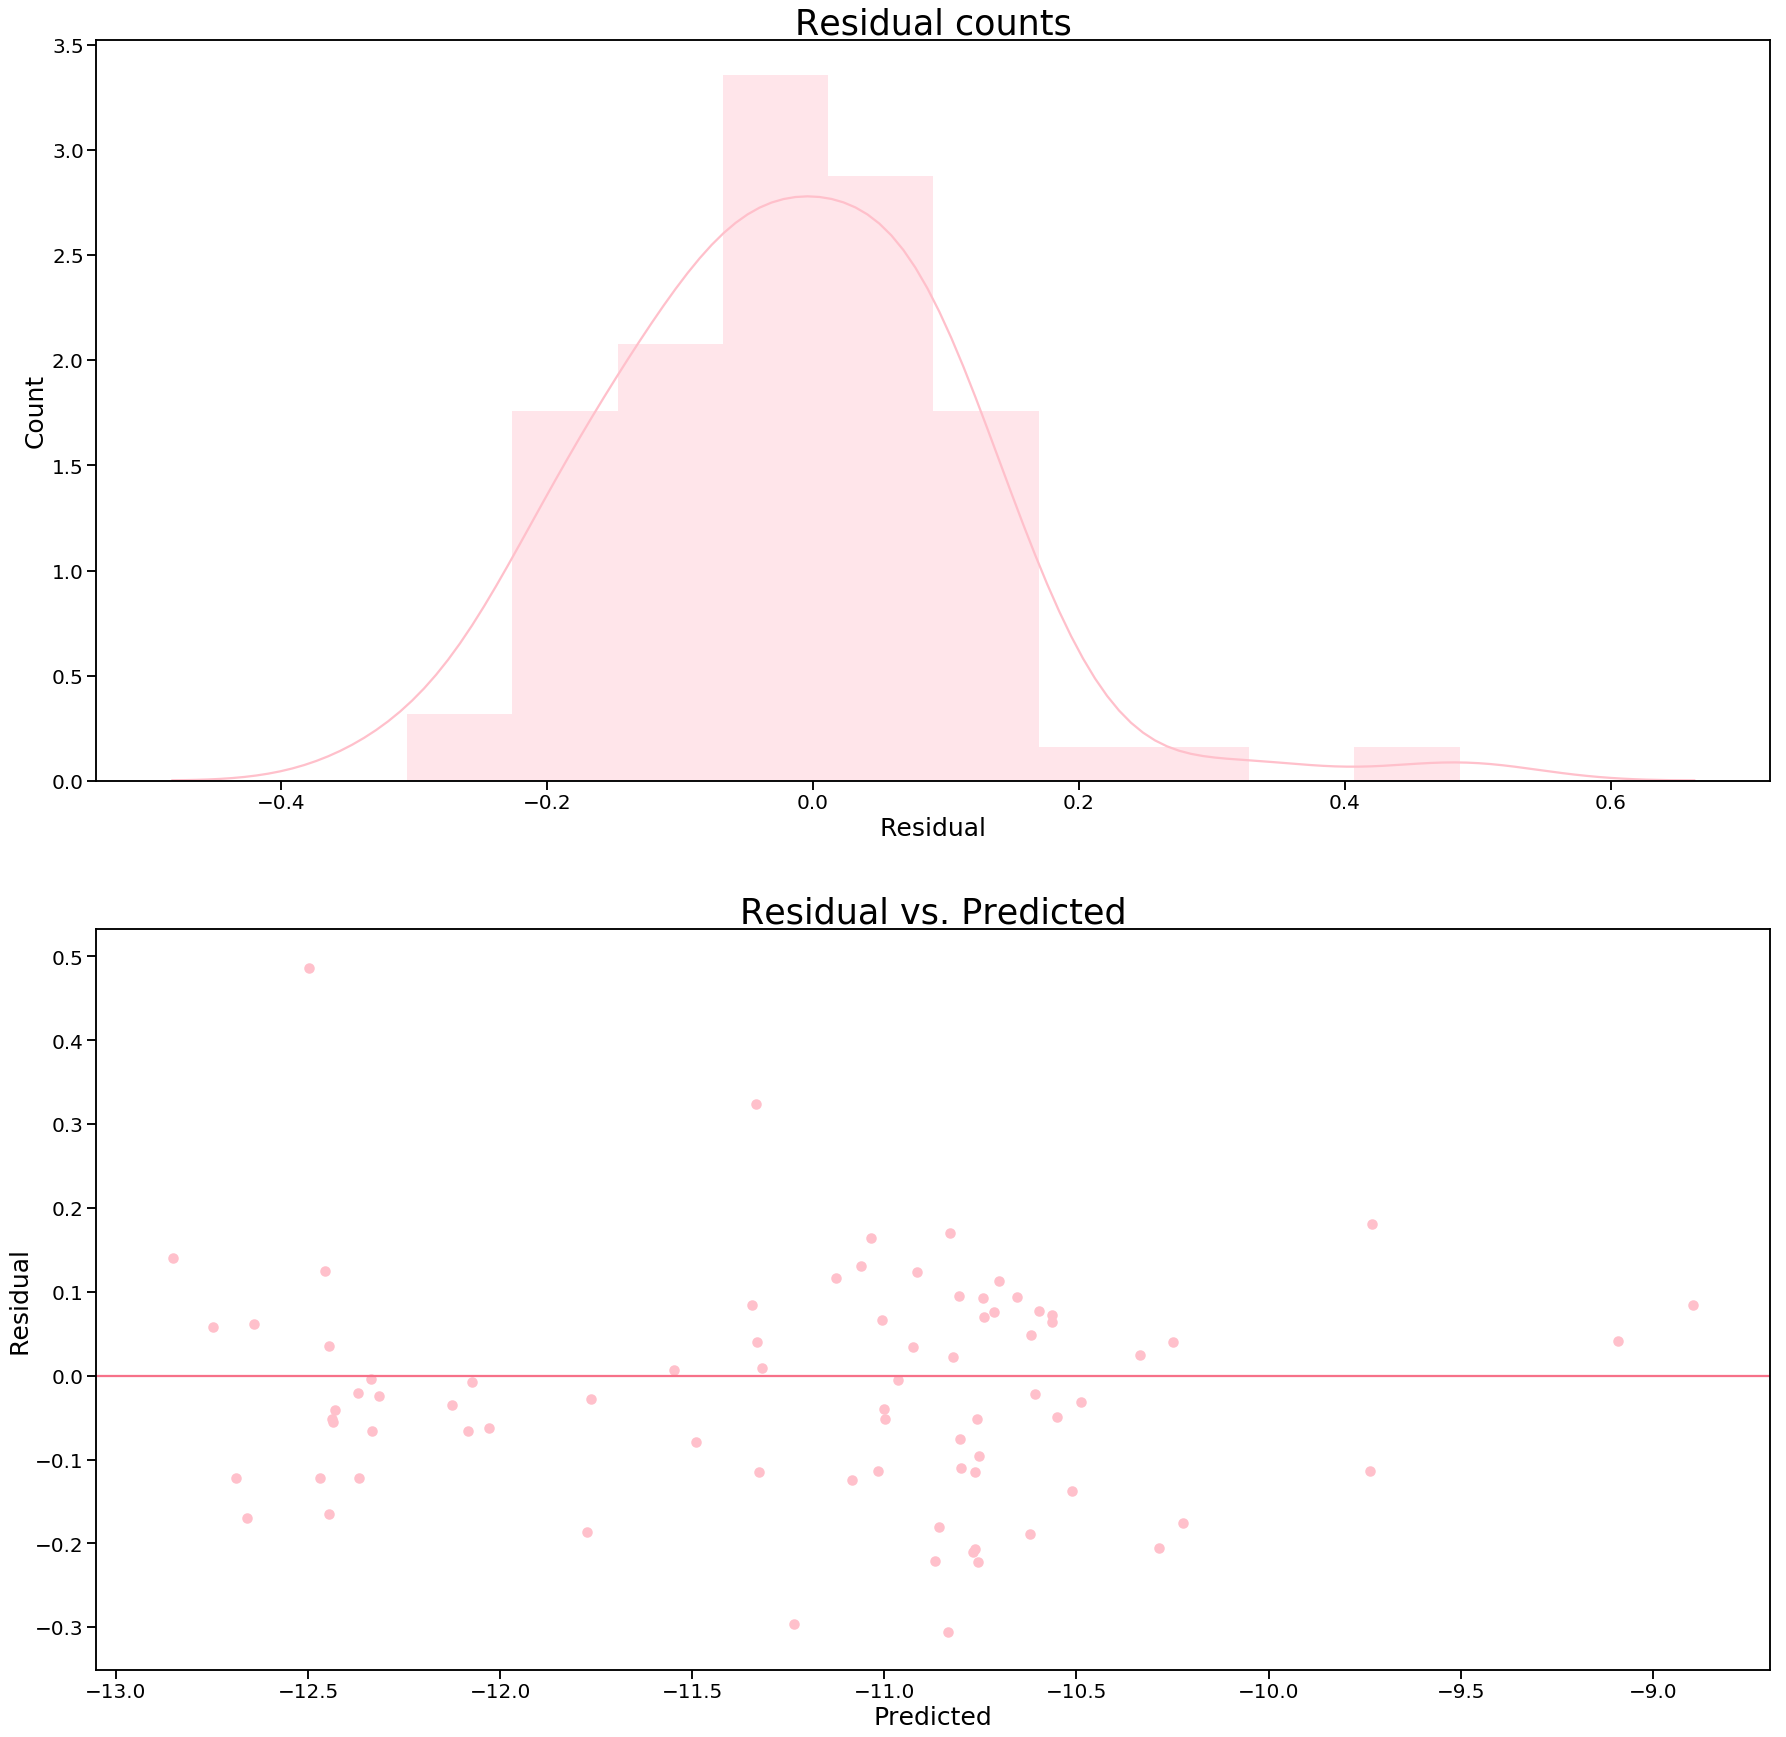

In [143]:
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='pink')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)
fig.savefig('regresion1.png', bbox_inches = "tight")

plt.show()

In [144]:
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=7, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [145]:
X_test= df_c_w.loc['2011-08-16':'2011--08-16']
X_test= X_test.append(df_c_w.loc['2011-11-29':'2011-11-29'])
X_test= X_test.append(df_c_w.loc['2012-03-26':'2012-03-26'])
X_test= X_test.append(df_c_w.loc['2012-06-13'])


In [146]:
X_test

,201 Depth,104 Depth,204 Depth,Precip,ETo,6_m_Prec_f,6_m_ETo_f,6-12_m_Prec_f,6-12_m_ETo_f,201_12_month_delta,104_12_month_delta,204_12_month_delta,10_m_Prec,10_m_ETo
2011-08-16,492.90,581.56,415.090909,0,6.853,119.0,577.937,169.0,1010.158,-7.52,-8.72,-11.749091,841.0,1195.001963
2011-11-29,494.06,583.39,408.620000,0,2.538,211.0,613.724,19.0,1000.007,NaN,NaN,NaN,475.0,1413.220000
2012-03-26,490.66,580.57,402.880000,10,3.553,84.0,1130.462,221.0,457.375,NaN,NaN,NaN,228.0,1256.370000
2012-06-13,495.69,586.10,417.410000,0,7.36,68.0,919.298,164.0,697.472,NaN,NaN,NaN,288.0,1157.385000


In [147]:
X1 = X_test.loc[:, (X_test.columns).isin(['6_m_Prec_f','6_m_ETo_f','6-12_m_Prec_f','6-12_m_ETo_f','10_m_Prec','10_m_ETo'])]


In [148]:
predicted1 = clf.predict(X1)
predicted1

array([ -8.74508541, -10.57336794, -12.50759651, -12.23339817])

In [149]:
print("Date,  ", "Previous Year,", "Forecast,", " Actual Value")
print('2012-08-16', 581.16, '>',581.16--8.77,'>', 594.53)
print('2012-11-29' , 583.39, '>',583.39--10.47,'>',  596.05)
print('2013-03-26' ,580.57 ,'>', 580.57--12.54, '>', 592.92)
print('2013-06-13' ,586.10, '>',586.10--12.18, '>', 598.98)


Date,   Previous Year, Forecast,  Actual Value
2012-08-16 581.16 > 589.93 > 594.53
2012-11-29 583.39 > 593.86 > 596.05
2013-03-26 580.57 > 593.11 > 592.92
2013-06-13 586.1 > 598.28 > 598.98


In [150]:
print ("Features sorted by their score:")
names = X.columns.values

feature_imp = (sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
             reverse=True))
print(feature_imp)

Features sorted by their score:
[(0.7415, '6_m_Prec_f'), (0.1007, '10_m_ETo'), (0.0763, '6-12_m_ETo_f'), (0.0503, '6_m_ETo_f'), (0.0231, '6-12_m_Prec_f'), (0.008, '10_m_Prec')]


In [154]:
feat_importances = pd.Series(clf.feature_importances_, index=X1.columns)
feat_importances2 = pd.DataFrame(data=feat_importances, columns=["Feature"])


In [155]:
feat_importances2.reset_index(level=0, inplace=True)


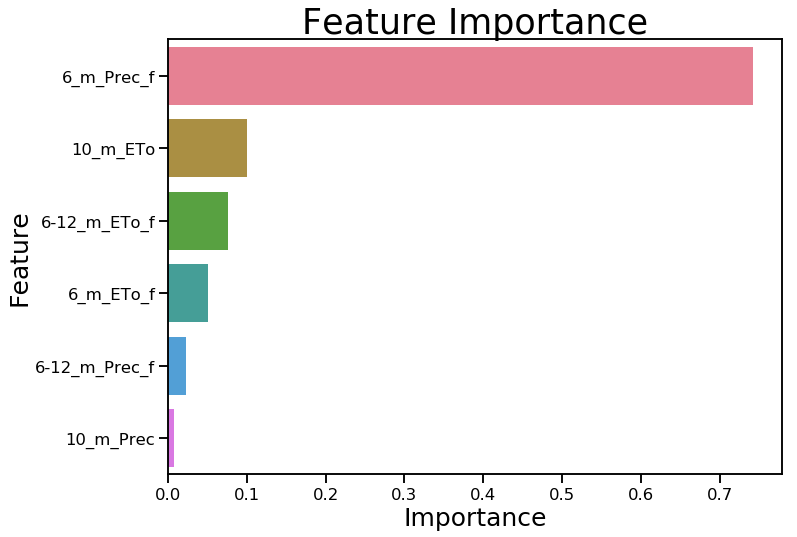

In [156]:
sns.set_context("talk")
sns.set_palette("husl")

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11, 8)
ax = sns.barplot(x="Feature",y="index", data =feat_importances2.sort_values("Feature",axis=0,ascending = False).iloc[:15])
plt.title('Feature Importance',fontsize=35)
plt.xlabel('Importance',fontsize=25)
plt.ylabel('Feature',fontsize=25)
fig.savefig('feature_importance.png', bbox_inches = "tight")


plt.show()

**Similar to Well 201, for well 104 the model does a better job of forecasting the values further in the future. In this case, the mean feature used by the model was the amount of precipitation in the next 6 months, followed by the amount of precipitation between 6 and 12 months in the future.**

# Conclusion.

**The machine learning model did a better job of predicting the water level compared to the ARIMA model, especially for those dates further in the future. 
As expected, the main features used by the machine learning models are one of the rainfall variables. Also, for each well model, the score for each one variable is different. This can be explained by the different physical characteristics of the terrain, which can delay the time it takes for the rain to infiltrate. 
One thing that could improve this model would be to get data about the amount of water pumped for each one of the wells.**